# EDA: processamento até dataset final e split treino/teste

Este notebook documenta o fluxo de preparação de dados para incidências cardiovasculares (SIM/SIH),
gerando série mensal `date,value` e divisão temporal em treino e teste para modelagem.

## 1) Setup e caminhos

Ajuste os caminhos se quiser usar outro arquivo bruto.

In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

ROOT = Path('/Users/f.filho/Projetos/labdaps/cardiovascular-timeseries-prediction')
RAW_CANDIDATES = [
    ROOT / 'data/raw/cv_sim_sample_10000_cases.csv',
    ROOT / 'data/raw/cv_sim_sample_5000_cases.csv',
    ROOT / 'data/raw/cv_sim_sample_1000_cases.csv',
]

raw_path = next((p for p in RAW_CANDIDATES if p.exists()), None)
if raw_path is None:
    raise FileNotFoundError('Nenhum arquivo bruto encontrado em data/raw/.')

processed_dir = ROOT / 'data/processed'
processed_dir.mkdir(parents=True, exist_ok=True)
final_series_path = processed_dir / 'serie_eventos_sp_cv_from_eda.csv'

print('Usando bruto:', raw_path)
print('Saída final:', final_series_path)

Usando bruto: /Users/f.filho/Projetos/labdaps/cardiovascular-timeseries-prediction/data/raw/cv_sim_sample_10000_cases.csv
Saída final: /Users/f.filho/Projetos/labdaps/cardiovascular-timeseries-prediction/data/processed/serie_eventos_sp_cv_from_eda.csv


## 2) Carregar dados brutos e inspeção inicial

In [2]:
df = pd.read_csv(raw_path)
print('Shape:', df.shape)
print('Colunas:', list(df.columns))
df.head()

Shape: (10000, 3)
Colunas: ['event_date', 'source', 'causabas']


,event_date,source,causabas
0,2020-01-07,SIM,I63
1,2020-01-15,SIM,I50
2,2020-01-29,SIM,I50
3,2020-01-26,SIM,I10
4,2020-01-11,SIM,I25


## 3) Definir incidência cardiovascular

Regras usadas:
- SIM: `CAUSABAS` (ou `causabas`) iniciando com `I` (CID-10 I00-I99).
- SIH: análogo usando `DIAG_PRINC` (quando aplicável).

In [3]:
cid_col = None
for c in ['CAUSABAS', 'causabas', 'DIAG_PRINC', 'diag_princ']:
    if c in df.columns:
        cid_col = c
        break
if cid_col is None:
    raise ValueError('Coluna CID não encontrada (CAUSABAS/DIAG_PRINC).')

df[cid_col] = df[cid_col].astype(str).str.upper().str.strip()
df_cv = df[df[cid_col].str.startswith('I')].copy()

print('CID usado:', cid_col)
print('Registros totais:', len(df))
print('Registros cardiovasculares:', len(df_cv))
print('Top CIDs:')
print(df_cv[cid_col].value_counts().head(10))

CID usado: causabas
Registros totais: 10000
Registros cardiovasculares: 10000
Top CIDs:
causabas
I10    2498
I50    1985
I21    1824
I63    1509
I25    1190
I64     994
Name: count, dtype: int64


## 4) Normalizar data de evento

In [4]:
date_col = None
for c in ['event_date', 'DTOBITO', 'DT_OBITO', 'DT_INTER', 'date']:
    if c in df_cv.columns:
        date_col = c
        break
if date_col is None:
    raise ValueError('Coluna de data não encontrada.')

df_cv['event_date'] = pd.to_datetime(df_cv[date_col], errors='coerce')
df_cv = df_cv.dropna(subset=['event_date']).copy()

print('Data usada:', date_col)
print('Data min:', df_cv['event_date'].min())
print('Data max:', df_cv['event_date'].max())
print('Registros válidos com data:', len(df_cv))

Data usada: event_date
Data min: 2020-01-01 00:00:00
Data max: 2023-12-31 00:00:00
Registros válidos com data: 10000


## 5) Agregar para série mensal final (`date,value`)

In [5]:
serie = (
    df_cv.assign(date=df_cv['event_date'].dt.to_period('M').dt.to_timestamp())
    .groupby('date', as_index=False)
    .size()
    .rename(columns={'size': 'value'})
    .sort_values('date')
)

serie.to_csv(final_series_path, index=False)
print('Série salva em:', final_series_path)
print('Pontos na série:', len(serie))
serie.head()

Série salva em: /Users/f.filho/Projetos/labdaps/cardiovascular-timeseries-prediction/data/processed/serie_eventos_sp_cv_from_eda.csv
Pontos na série: 48


,date,value
0,2020-01-01,171
1,2020-02-01,175
2,2020-03-01,191
3,2020-04-01,210
4,2020-05-01,219


## 6) Visualização rápida da série

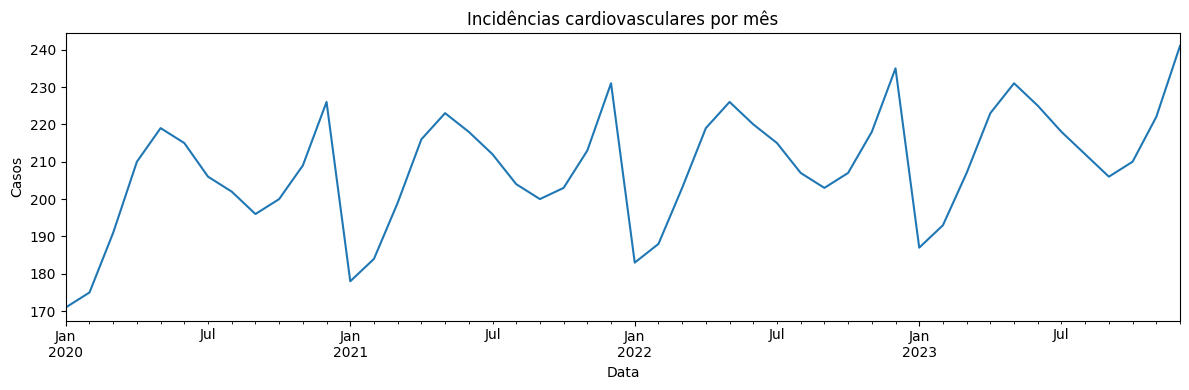

In [6]:
ax = serie.plot(x='date', y='value', figsize=(12, 4), legend=False, title='Incidências cardiovasculares por mês')
ax.set_xlabel('Data')
ax.set_ylabel('Casos')
plt.tight_layout()
plt.show()

## 7) Split temporal em treino e teste

Exemplo padrão: últimos 6 meses para teste (`horizon=6`).

In [7]:
horizon = 6
if len(serie) <= horizon:
    raise ValueError('Série curta demais para split com horizon=6.')

train_df = serie.iloc[:-horizon].copy()
test_df = serie.iloc[-horizon:].copy()

print('Treino:', len(train_df), 'pontos |', train_df['date'].min(), '->', train_df['date'].max())
print('Teste :', len(test_df), 'pontos |', test_df['date'].min(), '->', test_df['date'].max())

display(train_df.tail())
display(test_df)

Treino: 42 pontos | 2020-01-01 00:00:00 -> 2023-06-01 00:00:00
Teste : 6 pontos | 2023-07-01 00:00:00 -> 2023-12-01 00:00:00


,date,value
37,2023-02-01,193
38,2023-03-01,207
39,2023-04-01,223
40,2023-05-01,231
41,2023-06-01,225


,date,value
42,2023-07-01,218
43,2023-08-01,212
44,2023-09-01,206
45,2023-10-01,210
46,2023-11-01,222
47,2023-12-01,241


## 8) Próximo passo: rodar modelos

Com a série final pronta, rode:

```bash
PYTHONPATH=src python scripts/run_benchmark.py \
  --input-csv data/processed/serie_eventos_sp_cv_from_eda.csv \
  --date-col date \
  --value-col value \
  --freq MS \
  --horizon 6 \
  --min-train-size 24 \
  --models sarima,prophet,timesfm \
  --output-prefix results/benchmark_cv_from_eda
```